In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from scipy.integrate import odeint
from scipy.stats import linregress as lr
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

On va étudier le covid sur 2 critères : le nombre de cas avéré ainsi que le nombre de mort. 
rappel des dates importantes en france : 
9 mars interdiction des rassemblement de plus de 1000 personnes
14 mars stade 3 
17 mars midi debut du confinement 

# Pré processing de la base de données 

In [103]:
df = pd.read_csv('./Donnees')
df.shape # 17367 lignes mais on va prendre que les cas francais 
df.head()  # countriesAndTerritories nom de la colonne a filtrer
dfFr = df.loc[df['countriesAndTerritories']=="France",:]
dfFr.tail() # Nos données s'étende du 31 decembre 2019 au 16 mai 2020
dfFr.head()
dfFr = dfFr.sort_values(by=['year','month','day'])
df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,29/05/2020,29,5,2020,580,8,Afghanistan,AF,AFG,37172386.0,Asia
1,28/05/2020,28,5,2020,625,7,Afghanistan,AF,AFG,37172386.0,Asia
2,27/05/2020,27,5,2020,658,1,Afghanistan,AF,AFG,37172386.0,Asia
3,26/05/2020,26,5,2020,591,1,Afghanistan,AF,AFG,37172386.0,Asia
4,25/05/2020,25,5,2020,584,2,Afghanistan,AF,AFG,37172386.0,Asia


Nous partons d'une base de données mondiales et nous selectionnons unisquement les données francaise. DE plus nous rangeons les données dans un ordre chronologique. 

Text(0.5, 1.0, 'Data as a function of time ')

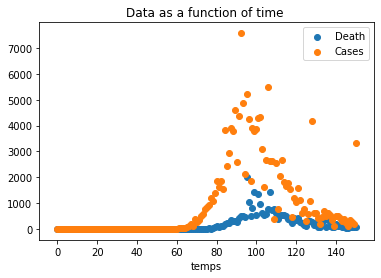

In [105]:
dfFr_plein = dfFr[['dateRep' , 'deaths' , 'cases']]
dfFr_plein.shape  # 138 lignes 

plt.scatter(np.linspace(0,len(dfFr_plein)-1 , len(dfFr_plein)) ,dfFr_plein['deaths'] , label = 'Death')
plt.scatter(np.linspace(0,len(dfFr_plein)-1 , len(dfFr_plein)) ,dfFr_plein['cases'] , label = 'Cases')
plt.xlabel('temps') 
plt.legend()
plt.title('Data as a function of time ')


Le profil semble assez similaire entre les 2 types de données a savoir le nombre de cas et le nombre de mort maintenant on remarque imédiatement que sur toute la durée de l'épidemis nous n'avons pas un profil expo. 

## Nettoyage des données car trop de 0 
On nettoie pour pouvoir creer notre modèle 

In [4]:
dfFrd = dfFr.loc[(dfFr['deaths']!= 0) & (dfFr['month']!=2),:] 
dfFrd.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
6706,03/03/2020,3,3,2020,48,1,France,FR,FRA,66987244.0,Europe
6705,04/03/2020,4,3,2020,34,1,France,FR,FRA,66987244.0,Europe
6703,06/03/2020,6,3,2020,138,3,France,FR,FRA,66987244.0,Europe
6702,07/03/2020,7,3,2020,190,2,France,FR,FRA,66987244.0,Europe
6701,08/03/2020,8,3,2020,103,1,France,FR,FRA,66987244.0,Europe


Nous avons une base de données de 74 éléments s'étalant du 3 mars au 16 mai pour notre études des morts 

In [5]:
dfFrc = dfFr.loc[(dfFr['cases']!=0)& (dfFr['month'].isin([2,3,4,5])) ,:] 
dfFrc = dfFrc[2:]
dfFrc.head()
#len(dfFrc)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
6712,26/02/2020,26,2,2020,2,0,France,FR,FRA,66987244.0,Europe
6711,27/02/2020,27,2,2020,3,1,France,FR,FRA,66987244.0,Europe
6710,28/02/2020,28,2,2020,21,0,France,FR,FRA,66987244.0,Europe
6709,29/02/2020,29,2,2020,19,0,France,FR,FRA,66987244.0,Europe
6708,01/03/2020,1,3,2020,43,0,France,FR,FRA,66987244.0,Europe


On a une base de données continue de 81 éléments du 26 fevrier au 16 mai pour notre études des cas positifs au covid

## Approche par régression linéaire 

Nous linéarisons le problème en passant au log car on cherche une solution expo

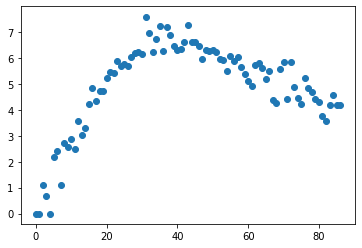

In [7]:
plt.scatter(np.linspace(0,len(dfFrd)-1 , len(dfFrd)) ,np.log(dfFrd['deaths']) , label = 'Morts')

On a un profil expo jusqu'au 30eme jour donc le debut du confinement auquel on ajoute 14 jours pour déclarer des symptomes on tombe sur le 2 avril 

In [246]:
fitd = lr(range(33) ,np.log(dfFrc['cases'][0:33]))
fitd[1]

2.506576111421347

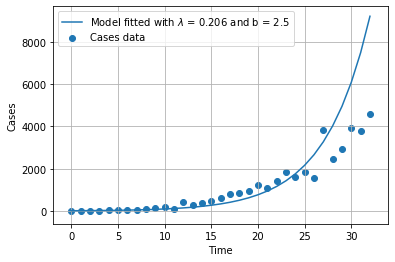

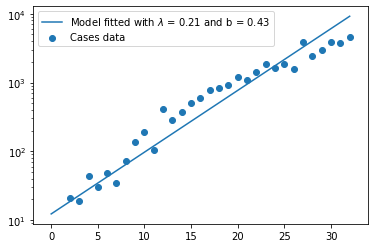

In [248]:
fig1, ax1 = plt.subplots() 
fig1, ax2 = plt.subplots()
ax1.plot(range(33), np.exp(fitd[0]*np.linspace(0,32,33) +fitd[1]), color='C0', label='Model fitted with $\lambda$ = 0.206 and b = 2.5')
ax1.scatter(range(33) ,dfFrc['cases'][0:33] , label = 'Cases data')
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Cases')
ax1.grid()
ax2.plot(range(33), np.exp(fitd[0]*np.linspace(0,32,33) +fitd[1]), color='C0', label='Model fitted with $\lambda$ = 0.21 and b = 0.43')
ax2.scatter(range(33) ,dfFrc['cases'][0:33] , label = 'Cases data')
ax2.legend()
ax2.set_yscale('log')


Nous constatons que le modèle expo est satisfesant bien que sur les 4 dèrniere valeurs nous nous éloignons deja du modèle. 

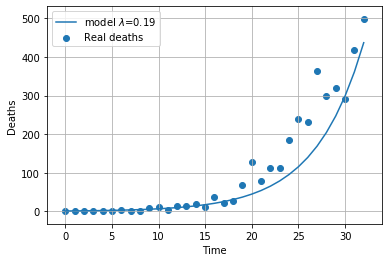

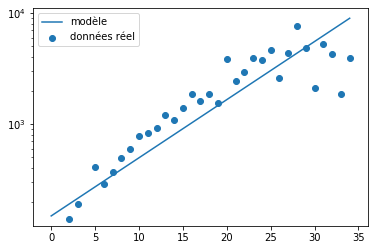

In [225]:
#plt.scatter(np.linspace(0,len(dfFr)-1 , len(dfFr)) ,np.log(dfFrc['cases']) , label = 'Cas')
#fitc = lr(range(35) ,np.log(dfFrd['cases'][0:33]))
fig1, ax1 = plt.subplots() 
fig1, ax2 = plt.subplots()
ax1.plot(range(33), np.exp(0.19*np.linspace(0,32,3) ), color='C0', label='modèle')
ax1.scatter(range(35) ,dfFr['cases'][60:93] , label = 'données réel')
ax1.legend()
ax1.set_xlabel('Temps')
ax1.set_ylabel('Nombre de cas')
ax1.grid()
ax2.plot(range(35), np.exp(fitc[0]*np.linspace(0,34,35) +fitc[1]), color='C0', label='modèle')
ax2.scatter(range(35) ,dfFrd['cases'][0:35] , label = 'données réel')
ax2.legend()
ax2.set_yscale('log')

Le confinement é

In [11]:
# recherche du meilleur R2 
R2 = 0 

for i in range (10):
    fitd = lr(range(25+i) ,np.log(dfFrd['deaths'][0:25+i]))
    if fitd[2] > abs(R2) : 
        R2 = fitd[2]
        sol=fitd
        isol = i
        
print(sol , isol)

LinregressResult(slope=0.21787620824094456, intercept=0.4329586350250212, rvalue=0.9706216425250707, pvalue=9.675624281581693e-21, stderr=0.009700505592454008) 8


# Implementation du SIR 

In [12]:
# densité initiale de la population
i0 = 1/(67*10**6)
r0 =0
s0=1-(i0+r0)
# encapsulation de la densité initiale
etat0_cov = np.array([i0,r0,s0])

# paramètres du modèle
b = 0.31
y = 0.09

params_cov = np.array([b, y ])

t0 = 0.0
tf = 150
dt = 0.01

tspan = np.arange(t0,tf,dt)

In [13]:
def covid(etat , t , params) :
    i,r,s =etat
    b1,y1 = params
    sdot= -b1*s*i
    idot= b1*s*i - y1*i
    rdot= y1*i

    return [idot,rdot,sdot]

In [14]:
cov = odeint(covid , etat0_cov, tspan, args=(params_cov,))

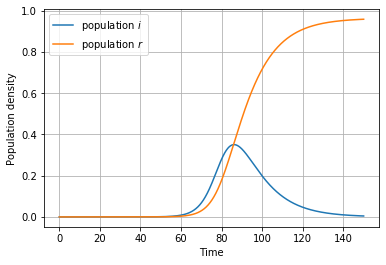

In [249]:
fig1, ax1 = plt.subplots() 
ax1.plot(tspan, cov[:,0], color='C0', label='population $i$')
ax1.plot(tspan, cov[:,1], color='C1', label='population $r$')
#ax1.plot(tspan, , color='C2', label='population mort')
i=0 
s=y/b

ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Population density')
ax1.grid()

In [16]:
# densité initiale de la population
i0 = 1/(67*10**6)
r0 =0
s0=1-(i0+r0)
# encapsulation de la densité initiale
etat0_covc = np.array([i0,r0,s0])

# paramètres du modèle
b = 0.31
y = 0.09
c = 0.25

params_covc = np.array([b, y ,c])

In [17]:
def covidc(etat , t , params) :
    i,r,s =etat
    b1,y1,c1 = params
    sdot= -(1-c)*b1*s*i
    idot= (1-c)*b1*s*i - y1*i
    rdot= y1*i

    return [idot,rdot,sdot]

In [25]:
tspann = np.arange(50,90,dt)
tspanc = np.arange(90,132,dt)
tspanf = np.arange(132,tf,dt)
tfi=np.concatenate((tspann,tspanc,tspanf))

#covc0 = odeint(covid , etat0_cov, tfi, args=(params_cov,))

c=0.9
covcn = odeint(covid , etat0_cov, tspann, args=(params_cov,))
covcc = odeint(covidc , np.array([covcn[-1,0],covcn[-1,1],covcn[-1,2]]), tspanc, args=(params_covc,))
c=0.85
covcf = odeint(covidc , np.array([covcc[-1,0],covcc[-1,1],covcc[-1,2]]), tspanf, args=(params_covc,))
covc = np.concatenate((covcn , covcc,covcf))

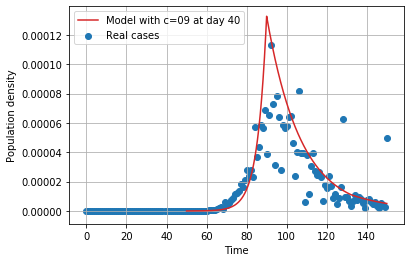

In [250]:
fig1, ax1 = plt.subplots() 
ax1.plot(tfi, covc[:,0], color='C3', label='Model with c=0.9 at day 40')
plt.scatter(np.linspace(0,len(dfFr_plein)-1 , len(dfFr_plein)) ,dfFr_plein['cases'] * 1/(67*10**6) , label = 'Real cases')
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Population density')
ax1.grid()

In [280]:
#c en fonction avec 2 stade de deconf 
def c1(t , tc , tdc ,tdc2 , conf , dconf , dconf2): 
    if (tdc <= t < tdc2) : 
        return dconf 
    if (tc<= t < tdc) :
        return conf
    if (t>= tdc2) : 
        return dconf2
    return 0
def c(t , tc , tdc  , conf , dconf ): 
    if (tdc <= t ) : 
        return dconf 
    if (tc<= t < tdc) :
        return conf
   
    return 0



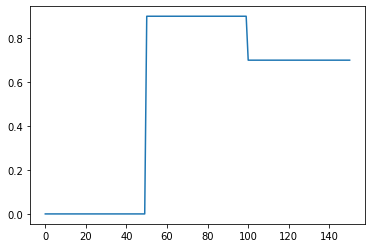

In [282]:
C= []
for i in range(151):
    C.append(c(i,50 , 100 , 0.9 , 0.7 ))
plt.plot(np.linspace(0,150,151) , C)

In [31]:
def numjouran(d): 
    j, m, a = d
    if ((a%4==0 and a%100!=0) or a%400==0):  
        return (0,31,60,91,121,152,182,213,244,274,305,335,366)[m-1] + j
    else:
        return (0,31,59,90,120,151,181,212,243,273,304,334,365)[m-1] + j

In [283]:
def E(x) : 
    b , y , conf , deconf  = x # ajouteer deconf2
    tspan = np.arange(50,len(dfFr_plein),1)
    tc=90 
    tdc = 130
    #tdc2 = 148 # A decommenter quand on aura assez de données 

    # Modèle SIR avec les bon paramètre initiaux 
    def covidc2(etat , t , params ) :
        i,r,s =etat
        b1,y1 = params
        sdot= -(1-c(t,tc , tdc , conf , deconf))*b1*s*i  # Ici utiliser c1 
        idot= (1-c(t,tc , tdc , conf , deconf))*b1*s*i - y1*i
        rdot= y1*i

        return [idot,rdot,sdot]
    S=0
    covcc=odeint(covidc2 , etat0_cov, tspan, args=([b,y],)) # Calcul du modèle 
    debut = np.zeros((50))
    cov = np.concatenate((debut , covcc[:,0]))
    
    for i in range(len(Ytrain)-1) :
        i+=1
        date =[]
        date.append(Ytrain.iat[i,1])
        date.append(Ytrain.iat[i,2])
        date.append(Ytrain.iat[i,3])
        tempsi = numjouran(date) # choix de la bonne dat epour coincider avec Ytrain 
        
        S += np.linalg.norm(cov[tempsi] - Ytrain.iat[i,4] * 1/(67*10**6)) # Erreur du modèle 
    return S

In [42]:
Ytrain , Ytest = train_test_split(dfFr,test_size=0.3)

Ytrain = Ytrain.sort_values(by=['year','month','day'])
Ytest = Ytest.sort_values(by=['year','month','day'])

In [148]:
h = 1e-6
gradB = (E([0.31 + h ,0.09,0.9,0.75 ]) - E([0.31 -h  ,0.09,0.9,0.75])) / (2*h)
gradY = (E([0.31  ,0.09 +h,0.9,0.75]) - E([0.31  ,0.09-h,0.9,0.75])) / (2*h)
gradConf = (E([0.31  ,0.09,0.9 +h,0.75]) - E([0.31  ,0.09,0.9-h,0.75])) / (2*h)
gradDeconf =(E([0.31  ,0.09,0.9,0.75 + h]) - E([0.31  ,0.09,0.9,0.75-h])) / (2*h)

def grad(x):
    b , y , conf , deconf = x 
    gradB = (E([b + h , y ,conf ,deconf ]) - E([b -h ,y ,conf , deconf])) / (2*h)
    gradY = (E([b ,y + h ,conf , deconf]) - E([b ,y-h ,conf , deconf])) / (2*h)
    gradConf = (E([b ,y ,conf + h , deconf]) - E([b ,y ,conf-h , deconf])) / (2*h)
    gradDeconf =(E([b ,y ,conf , deconf + h]) - E([b ,y ,conf , deconf-h])) / (2*h)
    return np.array([gradB ,gradY ,gradConf ,gradDeconf])

print( 1, grad([0.31 , 0.09 , 0.9 , 0.75]))
print(gradB , gradY , gradConf , gradDeconf)


1 [ 0.0590289  -0.07335221 -0.00508837 -0.00040778]
0.05902889732274739 -0.07335221101351228 -0.005088367978215488 -0.0004077755983897778


In [96]:
x0 = np.array([0.3,0.09,0.9,0.75])
res = minimize(E, x0 ,method='nelder-mead'
                ,options={'xatol': 1e-6, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000517
         Iterations: 256
         Function evaluations: 496


In [97]:
res.x

array([0.30441123, 0.09132288, 0.88227966, 0.78085892])

Text(0, 0.5, 'Cases')

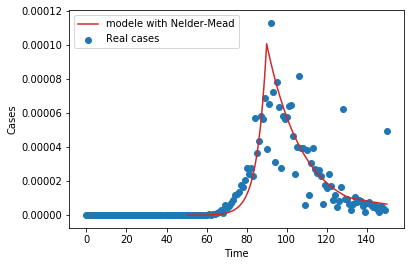

In [256]:
tc = 90
tdc = 130
conf = res.x[2]
dconf = res.x[3]
def covidc1(etat , t , params ) :
    i,r,s =etat
    b1,y1 = params
    sdot= -(1-c(t,tc , tdc , conf , dconf))*b1*s*i    
    idot= (1-c(t,tc , tdc , conf , dconf))*b1*s*i - y1*i
    rdot= y1*i

    return [idot,rdot,sdot]
tspannn = np.arange(50,len(dfFr_plein),1)
covcc=odeint(covidc1 , etat0_cov, tspannn, args=([res.x[0],res.x[1]],))
plt.plot(tspannn, covcc[:,0], color='C3', label='modele with Nelder-Mead')
plt.scatter(np.linspace(0,len(dfFr_plein)-1 , len(dfFr_plein)) ,dfFr_plein['cases'] * 1/(67*10**6) , label = 'Real cases')
plt.legend(loc = 'upper left')
plt.xlabel('Time')
plt.ylabel('Cases')

In [149]:
res1 = minimize(E, x0, method='BFGS', jac=grad ,options={'disp': True})

         Current function value: 0.000539
         Iterations: 5
         Function evaluations: 87
         Gradient evaluations: 77


In [150]:
res1.x

array([0.29350294, 0.08351316, 0.89545332, 0.7505262 ])

Text(0, 0.5, 'Cases')

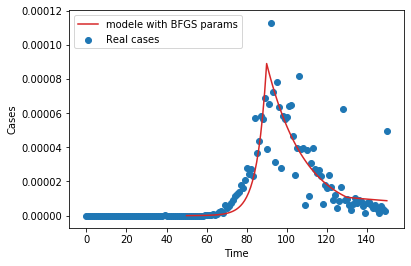

In [257]:
tc = 90
tdc = 130
conf = res1.x[2]
dconf = res1.x[3]
def covidc1(etat , t , params ) :
    i,r,s =etat
    b1,y1 = params
    sdot= -(1-c(t,tc , tdc , conf , dconf))*b1*s*i
    idot= (1-c(t,tc , tdc , conf , dconf))*b1*s*i - y1*i
    rdot= y1*i

    return [idot,rdot,sdot]
tspannn = np.arange(50,len(dfFr_plein),1)
covcc=odeint(covidc1 , etat0_cov, tspannn, args=([res1.x[0],res1.x[1]],))
plt.plot(tspannn, covcc[:,0], color='C3', label='modele with BFGS params')
plt.scatter(np.linspace(0,len(dfFr_plein)-1 , len(dfFr_plein)) ,dfFr_plein['cases'] * 1/(67*10**6) , label = 'Real cases')
plt.legend(loc = 'upper left')
plt.xlabel('Time')
plt.ylabel('Cases')

In [261]:
# Erreur de prediction : 
def Erreur(mod , Ytest , eps) : 
    S=0
    debut = np.zeros((50))
    cov = np.concatenate((debut , mod[:,0]))
    for i in range(len(Ytest)-1) :
        i+=1
        date =[]
        date.append(Ytest.iat[i,1])
        date.append(Ytest.iat[i,2])
        date.append(Ytest.iat[i,3])
        tempsi = numjouran(date) # choix de la bonne dat epour coincider avec Ytrain 
        
        err = np.linalg.norm(cov[tempsi] - Ytest.iat[i,4] * 1/(67*10**6)) # Erreur du modèle 
        
        if (err > eps) : 
            S+= 1
    return S
print ('Pourcentage d\'erreur a 1e-6 : ' ,(Erreur(covcc , Ytest , 1e-6)/len(Ytest) )*100)
print ('Pourcentage d\'erreur a 1e-5 : ' ,(Erreur(covcc , Ytest , 1e-5)/len(Ytest) )*100)
print ('Pourcentage d\'erreur a 1e-4 : ' ,(Erreur(covcc , Ytest , 1e-3)/len(Ytest) )*100)

Pourcentage d'erreur a 1e-6 :  45.65217391304348
Pourcentage d'erreur a 1e-5 :  17.391304347826086
Pourcentage d'erreur a 1e-4 :  0.0


In [112]:
def pas(d1 , D1 , rho , u1 , J ) : 
    return (1/2) * np.sum(d1*D1)*rho**2 / (np.sum(d1*D1)*rho + J(u1) - J(u1+rho*d1))

In [188]:
def DY(eps , Kmax , u0 , J , D ):
    N= len(u0)
    grad = D(u0)
    d0 = -grad
    S = np.zeros(Kmax)
    rho = 0.0104

    i=0
    while (i<Kmax and np.linalg.norm(d0)>eps) :
        u1 = u0 + rho*d0
        beta = np.dot(np.transpose(D(u1)),D(u1))/(np.dot(np.transpose(D(u1)-grad),d0)) 
        d1 = -D(u1) + beta*d0       
        rho = pas(d1 , D(u1), rho , u1, J )
        
        u0 = u1
        d0 = d1
        J0 = J(u1)
        grad = D(u1)
        S[i]=J0
        i+=1
    print( 'DY', i)
   # print( 'u = ',u0)
    return u0

In [190]:
x0 = np.array([0.3,0.09,0.9,0.75])
res2 =DY(1e-3 , 1500 , x0 , E , grad )

DY 69


Text(0, 0.5, 'Cases')

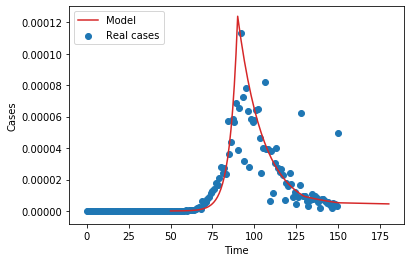

In [279]:
tc = 90
tdc = 130
tdc2 = 150
conf = res2[2]
dconf = res2[3]
dconf2 = 0.70
def covidc1(etat , t , params ) :
    i,r,s =etat
    b1,y1 = params
    sdot= -(1-c1(t,tc , tdc ,tdc2, conf , dconf , dconf2))*b1*s*i   ## remettre c si c'est pas a but predictif 
    idot= (1-c1(t,tc , tdc ,tdc2, conf , dconf , dconf2))*b1*s*i - y1*i
    rdot= y1*i

    return [idot,rdot,sdot]
tspannn = np.arange(50,len(dfFr_plein)+30,1)
covcc=odeint(covidc1 , etat0_cov, tspannn, args=([res2[0],res2[1]],))
plt.plot(tspannn, covcc[:,0], color='C3', label='Model ')
plt.scatter(np.linspace(0,len(dfFr_plein)-1 , len(dfFr_plein)) ,dfFr_plein['cases'] * 1/(67*10**6) , label = 'Real cases')
plt.legend(loc = 'upper left')
plt.xlabel('Time')
plt.ylabel('Cases')

In [197]:
print(res.x , 'nm')
print(res1.x , 'BFGS')
print(res2 , 'DY')

[0.30441123 0.09132288 0.88227966 0.78085892] nm
[0.29350294 0.08351316 0.89545332 0.7505262 ] BFGS
[0.3187771  0.10055373 0.88916335 0.77396615] DY
